We'll be looking at CIFAR-10 : it has 10 classes - (0), automobile (1), bird (2), cat (3),deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).

In [35]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

## dataset loading and prep

In [2]:

data_path = "../data_unversioned/p1ch7/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100.0%
Extracting ../data_unversioned/p1ch7/cifar-10-python.tar.gz to ../data_unversioned/p1ch7/
Files already downloaded and verified


A pytorch `Dataset` doesn't have to hold the data, but performs uniform access to it, by ensuring it's subclasses implement `__len__` (for `len(dataset)`) and `__getitem__` (for indexing, like `dataset[3]`).

It also can take in one or more `Transform`s, that will be applied before returning the item via `__getitem___`

In [3]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data_unversioned/p1ch7/
    Split: Train

In [4]:
cifar10_val

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data_unversioned/p1ch7/
    Split: Test

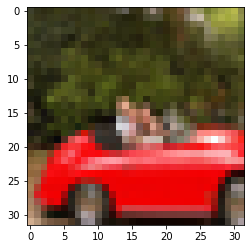

In [6]:
img, label = cifar10[99]
plt.imshow(img) # it's a PIL image

In [9]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform=transforms.ToTensor())

In [13]:
img_t, label = tensor_cifar10[99]
# note that the image is channel-first, the 3 color channels are at the zero index
img_t.shape, label

(torch.Size([3, 32, 32]), 1)

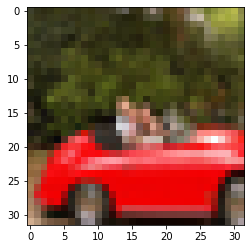

In [14]:
# it's C x H x W, we make it H x W x C to show it in matplotlib
plt.imshow(img_t.permute(1,2,0))

Normalizing data is important because
- it helps us learn faster, as it means it's more likely neurons have nonzero gradients from the activation function
- channel info can also be learned using the same learning rate, similar to why we normalized temerature data in the previous chapter.

In [19]:
# we need to compute the mean and std deviation so we can normalize info for every channel
# that is, we need to calculate mean and stddev for red parts f the image, green parts of the image, and so on

# the images in one tensor (stacking many tensors into one)
imgs = torch.stack([i for i,_ in tensor_cifar10])


In [20]:
imgs.shape

torch.Size([50000, 3, 32, 32])

In [27]:
# view returns a new tensor with the same underlying data but different shape
# (3,-1) means that we want the dimension 3, for channels. -1 means :figure the rest out", in this case flatten and combine 32x32X50000 for each channel
print(imgs.view(3,-1).shape)
# calc mean and std for 51200000, the channel data index is 1, thats why dim=1
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))


torch.Size([3, 51200000])
tensor([0.4741, 0.4727, 0.4733])
tensor([0.2521, 0.2520, 0.2506])


In [45]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4741, 0.4727, 0.4733), # the function doesnt calculate it, we have to do that ourselves
        (0.2521, 0.2520, 0.2506)
    )
]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4741, 0.4727, 0.4733), # the function doesnt calculate it, we have to do that ourselves
        (0.2521, 0.2520, 0.2506)
    )
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


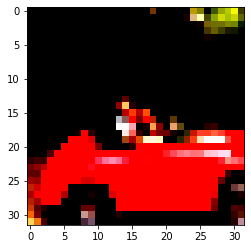

In [31]:
## let's see what the transformation did
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## telling birds from airplanes
- filter the dataset to have only bird and airplane data
- build a model that gives us a probability of it being a bird or an airplane (classification problem)

In [46]:
# manually filter everything except birds and airplanes.
# a better way could be to create a Dataset subclass, but this will do for now
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label])for img, label in transformed_cifar10_val if label in [0, 2]]

In [38]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [47]:
# the model. in the simplest case, we can just pass a flattened 1d vector
# this would mean it wont have any spatial info, like about rows and columns
model = nn.Sequential(
    nn.Linear(32*32*3, 512), # it takes in 11 features
    nn.Tanh(),
    nn.Linear(512, 2), # pass to softmax to get probability
    # can take a vector of any length, 2 here, and make sure they sum to one and are between [0,1].
    # we have to specify the dimension as the 0th index can have a batch
    nn.Softmax(dim=1) 
)
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


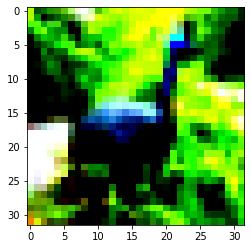

In [49]:
# let's get an output for an image on the untrained network
test_img, _ = cifar2[0]
plt.imshow(test_img.permute(1,2,0))

In [50]:
# unsqueeze to add a batch of one for this singular image
one_dim_tensor = test_img.view(-1).unsqueeze(0)
one_dim_tensor.shape

torch.Size([1, 3072])

In [58]:
# probabilities. If higher probability at index 0, then we select index 0, which is 'airplane'
model(one_dim_tensor).shape 

torch.Size([1, 2])

In [64]:
model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) 
)

In [62]:
train_cifar_images = torch.stack([i for i,_ in cifar2]).view(10000,-1)
train_cifar_labels = torch.tensor([l for _,l in cifar2])
print(train_cifar_images.shape)
print(train_cifar_labels.shape)


torch.Size([10000, 3072])
torch.Size([10000])


In [72]:
# example of using dataloader to create tensor batches
loader = torch.utils.data.DataLoader(list(range(1000)), batch_size=100, shuffle=True)
for x in loader:
    print(x.shape)

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


In [77]:
def training_loop(n_epochs, model, loss_fn, optimizer, dataloader):
    for i in range(1, n_epochs+1):
        # calculate for mini batches
        for imgs, labels in dataloader:
            optimizer.zero_grad() # clear to prevent gradients from accumulating on leaf nodes in comp. graph
            # img.size is [64, 3,32,32]
            # make it [64, 3*32*32]
            batch_size = imgs.shape[0]
            train_predicted = model(imgs.view(batch_size,-1))
            loss = loss_fn(train_predicted, labels)
            loss.backward() # update gradients and loss
            optimizer.step() # update params

    print(f"epoch {i} training loss {loss}")

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
# print(len(cifar2))
# for img, labels in train_loader:
#     print(img.shape)
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=torch.nn.NLLLoss(),
    optimizer=optimizer,
    dataloader=train_loader
)

epoch 100 training loss 0.7310789823532104
